In [1]:
import math
import copy
import torch
import random
import argparse

import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from math import sqrt
from tqdm import tqdm

from scipy.special import softmax

from utils import (
    generate_x,
    generate_y,
    conduct_gd,
    combine_input,
    
    SimpleAttn,
)



## case 1: gd with noise

$$
\Delta w_t = g_t + \xi^\top w_t \xi, ~~~   \xi \in \mathcal{N}(\delta^2 I, 0)\\
w_{t+1} = w_t - \eta \Delta w_t
$$

(1.251651906967163, 1.4516519069671632)

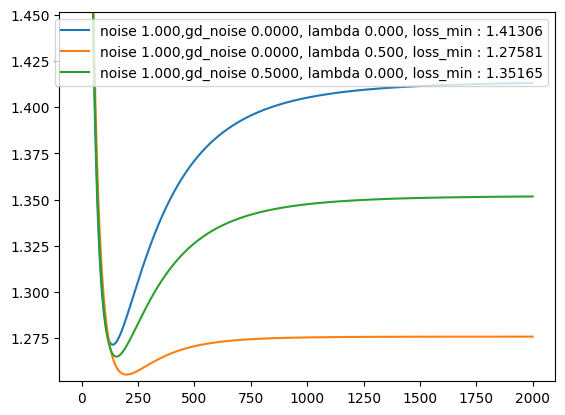

In [46]:
device      = "cuda:1"

x_dim       = 20
batch_num   = 1024
data_range  = 1
example_num = 30
choose_elements = 20
eta         = 1e-1
lbda        = 0.
noise       = 1
cot_steps   = 2000
gd_noise    = 0.
weight_range= 1
x_context = generate_x(example_num = example_num, x_dim = x_dim, batch_num = batch_num, data_range = data_range, xi = 0, device = device)
y_context, w_all = generate_y(x_all = x_context, weight_range = weight_range, noise = noise, device = device, few_shot = True, choose_elements = choose_elements)
sample_num  = 500

def conduct_gd(x_context, y_context, eta , w0 = None, steps = 1, lbda = 0, gd_noise = 0):
    device = x_context.device
    b,t,c = x_context.size()
    if w0 is None:
        wi = torch.zeros((b,c,1), device = device)
    else:
        wi = w0
    x_context_t = x_context.transpose(1, 2)  # b * c * t
    w_cot = [wi.transpose(1, 2).clone()]
    gd_noise_v = torch.randn(wi.size(), device = device) * gd_noise
    gd_noise_v = gd_noise_v.clip(min = -3 * gd_noise, max = 3 * gd_noise)
    for i in range(steps):
        
        wi -= eta / t * ((x_context_t @ (x_context @ wi - y_context)) + lbda * wi + (gd_noise_v.transpose(1, 2) @ wi) * gd_noise_v) 
        # wi -= eta / t * ((x_context_t @ (x_context @ (wi ) - y_context)) + lbda * wi + gd_noise_v * wi ) 
        # wi -= eta / t * ((x_context_t @ (x_context @ (wi + gd_noise_v)- y_context)) + lbda * wi ) 
        # + (torch.randn(wi.size(), device = device) * gd_noise)
        # b * c * t @ b * t * c @ b * c * 1 => b * c * 1
        w_cot.append(wi.transpose(1, 2).clone())
    
    w_cot = torch.concat(w_cot, dim = 1)
    return w_cot

with torch.no_grad():
    for lbda in [0,5e-1]:
        w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = lbda, gd_noise = 0)
        loss = (w_cot -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {0.:.4f}, lambda {lbda:.3f}, loss_min : {loss[-1]:.5f}")
    
    # for gd_noise in np.arange(1e-2, 1e-1, 2e-2 ):
    for gd_noise in [5e-1]:
        w_samples = torch.zeros_like(w_cot)
        for _ in range(sample_num):
            w_cot = conduct_gd(x_context, y_context, eta , w0 = None, steps = cot_steps, lbda = 0, gd_noise = gd_noise )
            w_samples += w_cot
        w_samples /= sample_num
        loss = (w_samples -  w_all[:,None,:]).norm(dim = -1).mean(dim = 0).cpu().numpy()
        sns.lineplot(x = np.arange(len(loss)), y = loss, label = f"noise {noise:.3f},gd_noise {gd_noise:.4f}, lambda {0.:.3f}, loss_min : {loss[-1]:.5f}")
plt.ylim(loss[-1]-1e-1,loss[-1]+1e-1)

In [265]:
gd_noise = 3e-1
x = torch.randn((100000,), device = device) * gd_noise
x = x.clip(min = -3 * gd_noise, max = 3 * gd_noise)
(1/(1 + x)).sum() / 100000

tensor(1.1381, device='cuda:1')

## case 2: sparse linear regression

### problem setting
$$
w^\star = [0,1,0,0,1,\cdots] \in \{0,1\}^d
$$

activation to token 
if $\max{|\Delta w_t|} > \delta$: 
$$
w_{t+1} = \tilde{w}_t - \eta \Delta w_t \\
\text{sample } k \text{ index based on } w_{t+1}, \text{ set value to 1, otherwise 0 } \rightarrow \tilde{w}_{t+1}
$$

In [59]:

def dropout_sparse_regression(X, y, n_iterations=1000, learning_rate=0.01, select_feature=4, start_weights=None, select_method = "sample", stop_eps = 1e-1):
    batch_size, N, n_features = X.shape
    
    # Initialize weights
    weights = np.zeros((batch_size, n_features)) if start_weights is None else start_weights
    
    # Pre-allocate arrays to avoid repeated allocations
    weights_copy = np.zeros_like(weights)
    gradient = np.zeros_like(weights)
    
    for _ in range(n_iterations):
        # Compute prediction using matrix multiplication
        y_pred = np.einsum('bnf,bf->bn', X, weights) 
        error = y_pred - y
        
        # Compute gradient using reshape for better performance
        gradient = np.einsum('bnf,bn->bf', X, error) 
        # print((error**2).mean(axis = -1).shape)
        # raise
        # Find batches that need updating
        # mask = np.max(gradient, axis=1) > 1e-3
        mask = (error**2).mean(axis = -1) > stop_eps
        if not np.any(mask):
            continue
            
        # Update only the necessary batches
        masked_indices = np.where(mask)[0]
        weights_copy[mask] -= learning_rate * gradient[mask]
        
        # Clip and normalize
        weights_copy = weights_copy.clip(min=1e-10)
        weights_copy[masked_indices] /= weights_copy[masked_indices].sum(axis=1, 
                                                                       keepdims=True)
        
        # Perform dropout
        for b in masked_indices:
            if select_method == "sample":
                weights_choice = np.random.choice(n_features, size=select_feature, 
                                            p=weights_copy[b], replace=False)
            elif select_method == "greedy":
                weights_choice = weights_copy[b].argsort()[-select_feature:]
            else:
                raise NotImplementedError
            weights_copy[b].fill(0)
            weights_copy[b, weights_choice] = 1
            
        weights[mask] = weights_copy[mask]
        weights_copy  = weights.copy()
    
    return weights, -learning_rate * gradient, (error**2).mean(axis = -1)

# Example usage
batch_size = 20
N = 40
dim = 400
select_feature = 2
noise_level = 0.5
noise_level = math.sqrt(noise_level **2 * select_feature)

# Generate batch data
X = np.random.randn(batch_size, N, dim)  # (batch_size, N, dim)
true_weights = np.zeros((batch_size, dim))
true_weights[:, ::(dim // select_feature)] = 1  # Make true weights sparse
# random_weight_noise = np.random.randn(*true_weights.shape) * noise_level
y = np.einsum('bnf,bf->bn', X, true_weights)  # (batch_size, N)
y += np.random.randn(*y.shape) * noise_level 
learning_rate = 1 / (N )

# Fit model
sparse_weights_all = []
count_dict = {b: {} for b in range(batch_size)}
count_list = [[] for _ in range(batch_size)]
err_dict = {b: {} for b in range(batch_size)}
for _ in tqdm(range(1000)):
    sparse_weights, delta_weights, errs = dropout_sparse_regression(X, y, n_iterations=100, 
                                                           learning_rate=learning_rate,
                                                           select_feature=select_feature, stop_eps = 2 * noise_level**2 )
                                                        #    select_feature=select_feature, stop_eps = 1e-2)

    # Process results for each batch
    for b in range(batch_size):
        result_id = int(''.join(str(int(x)) for x in sparse_weights[b]), 10)
        count_list[b].append(result_id)
        
        if result_id in count_dict[b]:
            count_dict[b][result_id] += 1
        else:
            count_dict[b][result_id] = 1
        err_dict[b][result_id] = errs[b]
        sparse_weights_all.append((
            abs(sparse_weights[b] - true_weights[b]).sum(),
            [j for j, i in enumerate(sparse_weights[b]) if i != 0],
            result_id
        ))

sparse_weights, delta_weights, errs = dropout_sparse_regression(X, y, n_iterations=100, 
                                                           learning_rate=learning_rate,
                                                           select_feature=select_feature, select_method = "greedy", stop_eps = 2 * noise_level**2)
    
# Process results for each batch
greedy_result = []
greedy_errs   = errs.copy()
for b in range(batch_size):
    result_id = int(''.join(str(int(x)) for x in sparse_weights[b]), 10)
    greedy_result += [result_id]


100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


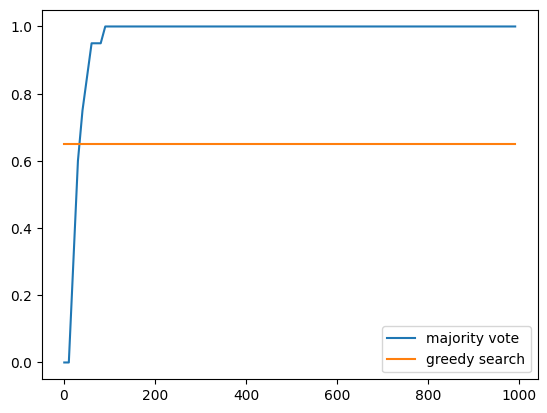

<Axes: >

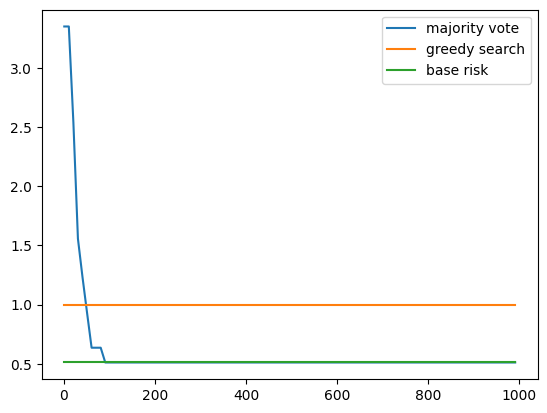

In [63]:
def get_major(count_list):
    count_dict = {}
    max_count = 0
    major_item = 0
    for binary_num in count_list:
        if binary_num in count_dict:
            count_dict[binary_num] += 1
        else:
            count_dict[binary_num] = 1
    for i in count_dict:
        if max_count < count_dict[i]:
            max_count = count_dict[i]
            major_item = i
    return major_item

def count_ones_in_binary(num):
    count = 0
    while num:
        count += num & 1
        num >>= 1
    return count

# Analyze results for each batch
error_lists = []
sample_num_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sample_num_list = np.arange(1,1000,10)
acc_all = []
end_all = []
error_all = []
for k in sample_num_list:
    acc_count = 0
    error_major_item = 0
    end_item_count = 0
    for b in range(batch_size):
        true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
        major_item = get_major(count_list[b][:k])
        acc_count += int(major_item == true_item)
        error_major_item += err_dict[b][major_item]
        end_item_count += int(err_dict[b][major_item] <= 2 * noise_level**2)
    acc_all += [acc_count / batch_size]
    end_all += [end_item_count / batch_size]
    error_all += [error_major_item / batch_size]
    
sns.lineplot(x = sample_num_list, y = acc_all, label = "majority vote")
# sns.lineplot(x = sample_num_list, y = end_all, label = "majority vote - end")
greedy_acc_count = 0
for b in range(batch_size):
    true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
    greedy_acc_count += int(greedy_result[b] == true_item)
greedy_acc = greedy_acc_count / batch_size
sns.lineplot(x=sample_num_list, y=[greedy_acc] * len(sample_num_list), label = "greedy search")
plt.show()

sns.lineplot(x = sample_num_list, y = error_all, label = "majority vote")
sns.lineplot(x=sample_num_list, y=[greedy_errs.mean()] * len(sample_num_list), label = "greedy search")
sns.lineplot(x=sample_num_list, y=[((np.einsum('bnf,bf->bn', X, true_weights) - y)**2).mean()] * len(sample_num_list), label = "base risk")
 

## case 2.2: sparse linear regression (add one item each step)

### problem setting (step by step)
$$
w^\star = [0,1,0,0,1,\cdots] \in \{0,1\}^d
$$

activation $w_{t+1}$ to discrete token $\tilde{w}_{t+1}$:

sample one index for adding: $i \sim  - \Delta w_t$

$$
w_{t+1} = \tilde{w}_t - \eta \Delta w_t
$$

example: 

$$
[0,0,0,0] \rightarrow [1,0,0,0] \rightarrow [1,0,1,0] \rightarrow [1,0,1,1]
$$

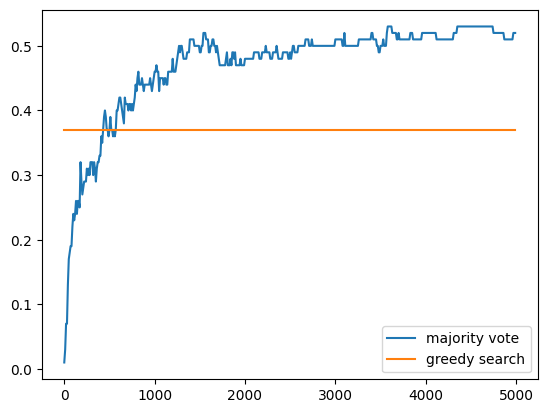

<Axes: >

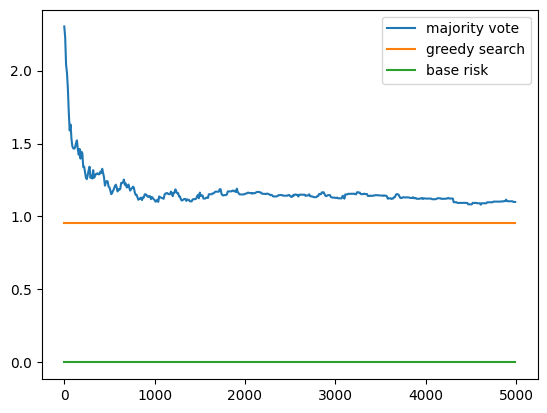

In [20]:
def get_major(count_list):
    count_dict = {}
    max_count = 0
    major_item = 0
    for binary_num in count_list:
        if binary_num in count_dict:
            count_dict[binary_num] += 1
        else:
            count_dict[binary_num] = 1
    for i in count_dict:
        if max_count < count_dict[i]:
            max_count = count_dict[i]
            major_item = i
    return major_item

def count_ones_in_binary(num):
    count = 0
    while num:
        count += num & 1
        num >>= 1
    return count

# Analyze results for each batch
error_lists = []
sample_num_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sample_num_list = np.arange(1,5000,10)
acc_all = []
error_all = []
for k in sample_num_list:
    acc_count = 0
    error_major_item = 0
    for b in range(batch_size):
        true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
        major_item = get_major(count_list[b][:k])
        acc_count += int(major_item == true_item)
        error_major_item += err_dict[b][major_item]
    acc_all += [acc_count / batch_size]
    error_all += [error_major_item / batch_size]
sns.lineplot(x = sample_num_list, y = acc_all, label = "majority vote")
greedy_acc_count = 0
for b in range(batch_size):
    true_item = int(''.join(str(int(x)) for x in true_weights[b]), 10)
    greedy_acc_count += int(greedy_result[b] == true_item)
greedy_acc = greedy_acc_count / batch_size
sns.lineplot(x=sample_num_list, y=[greedy_acc] * len(sample_num_list), label = "greedy search")
plt.show()

sns.lineplot(x = sample_num_list, y = error_all, label = "majority vote")
sns.lineplot(x=sample_num_list, y=[greedy_errs.mean()] * len(sample_num_list), label = "greedy search")
sns.lineplot(x=sample_num_list, y=[((np.einsum('bnf,bf->bn', X, true_weights) - y)**2).mean()] * len(sample_num_list), label = "base risk")
 